---
# __CÀI ĐẶT__

In [1]:
! pip install pyECLAT

In [2]:
! pip install mlxtend

---
# __THƯ VIỆN__

In [3]:
import pandas as pd
import numpy as np
import time
import math
import re
import itertools
import warnings
warnings.filterwarnings('ignore')
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from pyECLAT import ECLAT
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


---
# __ĐỌC DỮ LIỆU__

In [4]:
df = pd.read_csv('C:\\Users\\PC\\Downloads\\DATA MINING _ NHÓM 10\\Market Basket Analysis 1.csv', header=None)
# Quan sát bộ dữ liệu 
df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
7496,butter,light mayo,fresh bread,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7497,burgers,frozen vegetables,eggs,french fries,magazines,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7498,chicken,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7499,escalope,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7500,eggs,frozen smoothie,yogurt cake,low fat yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
# __XỬ LÝ VÀ MÔ TẢ DỮ LIỆU__

In [5]:
# Kích thước bộ dữ liệu
df.shape

(7501, 20)

In [6]:
# Quan sát các cột
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7501 non-null   object
 1   1       5747 non-null   object
 2   2       4389 non-null   object
 3   3       3345 non-null   object
 4   4       2529 non-null   object
 5   5       1864 non-null   object
 6   6       1369 non-null   object
 7   7       981 non-null    object
 8   8       654 non-null    object
 9   9       395 non-null    object
 10  10      256 non-null    object
 11  11      154 non-null    object
 12  12      87 non-null     object
 13  13      47 non-null     object
 14  14      25 non-null     object
 15  15      8 non-null      object
 16  16      4 non-null      object
 17  17      4 non-null      object
 18  18      3 non-null      object
 19  19      1 non-null      object
dtypes: object(20)
memory usage: 1.1+ MB


### __XỬ LÝ CÁC GIAO DỊCH CÓ ITEM TRÙNG__

In [7]:
def find_duplicate_transactions(df, num_columns):
    unique_counts = []
    for _, row in df.iterrows():
        unique_items = row.iloc[:num_columns].nunique()
        unique_counts.append(unique_items)
    df['num_uniq'] = unique_counts

    total_counts = []
    for _, row in df.iterrows():
        total_items = row.iloc[:num_columns].count()
        total_counts.append(total_items)
    df['num_item'] = total_counts

    duplicate_transactions = df[df['num_uniq'] != df['num_item']]
    return duplicate_transactions

In [8]:
### Các giao dịch chứa sản phẩm trùng
df1 = df.copy()
duplicate_items_transactions = find_duplicate_transactions(df1, num_columns=20)
duplicate_items_transactions

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,num_uniq,num_item
4394,burgers,ham,eggs,whole wheat rice,ham,french fries,cookies,green tea,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,8
4494,ham,eggs,honey,gums,light cream,ham,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,6
4526,ham,milk,chicken,whole wheat rice,ham,eggplant,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,6
6903,ground beef,spaghetti,mineral water,chocolate,salmon,chicken,chocolate,frozen smoothie,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,8
7109,ham,shrimp,milk,flax seed,salmon,corn,ham,eggplant,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,8


In [9]:
# Loại bỏ các sản phẩm trùng trong giao dịch
df = df.replace(np.nan, None)
df_cleaned = []
for _, row in df.iloc[:, 0:20].iterrows():
    temp = []
    for value in row:
        if value is not None and value not in temp:  
            temp.append(value)
    df_cleaned.append(temp)
df_cleaned = pd.DataFrame(df_cleaned)
df2 = df_cleaned.copy()
duplicate_items_transactions1 = find_duplicate_transactions(df2, num_columns=20)
print(f'Số giao dịch có sản phẩm trùng là: {len(duplicate_items_transactions1)}')

Số giao dịch có sản phẩm trùng là: 0


### __KHÁM PHÁ DỮ LIỆU__

#### __XÂY DỰNG TID-list__

In [10]:
df_transposed = df_cleaned.T
df_vertical = df_transposed.reset_index().melt(id_vars='index', value_name='Item', var_name='TransactionID')
df_vertical.columns = ['TransactionIndex', 'TransactionID', 'Item']
df_filtered = df_vertical[df_vertical['Item'].notna()]
df_filtered = df_filtered[df_filtered['Item'].apply(lambda x: isinstance(x, str))]
TID = df_filtered.groupby('Item')['TransactionID'].apply(list).reset_index()
TID['Total Transactions'] = TID['TransactionID'].apply(len)
TID = TID.sort_values(by='Total Transactions', ascending=False)
TID.head(5)

,Item,TransactionID,Total Transactions
72,mineral water,"[0, 4, 12, 14, 15, 18, 22, 26, 28, 29, 31, 37,...",1788
37,eggs,"[1, 10, 12, 17, 18, 20, 24, 28, 31, 51, 57, 64...",1348
100,spaghetti,"[8, 13, 18, 22, 25, 26, 29, 35, 40, 41, 42, 50...",1306
43,french fries,"[6, 9, 19, 28, 32, 36, 45, 54, 65, 80, 81, 82,...",1282
25,chocolate,"[16, 20, 28, 31, 33, 50, 53, 56, 66, 76, 86, 9...",1229


#### __KHÁM PHÁ__

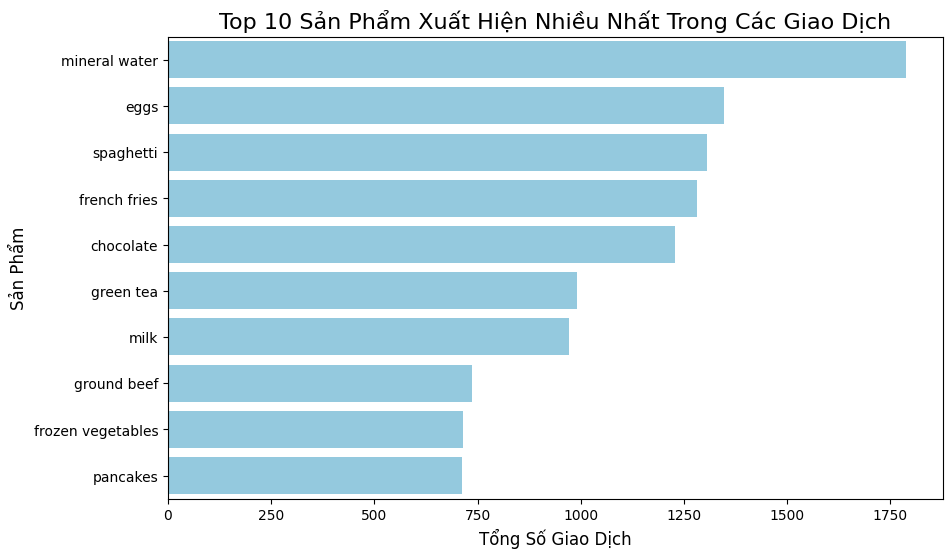

In [11]:
# Biểu đồ bar plot hiển thị top 10 sản phẩm xuất hiện nhiều nhất trong các giao dịch
top_10_products = TID.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Total Transactions', y='Item', data=top_10_products, color='skyblue')

plt.title('Top 10 Sản Phẩm Xuất Hiện Nhiều Nhất Trong Các Giao Dịch', fontsize=16)
plt.xlabel('Tổng Số Giao Dịch', fontsize=12)
plt.ylabel('Sản Phẩm', fontsize=12)

plt.show()


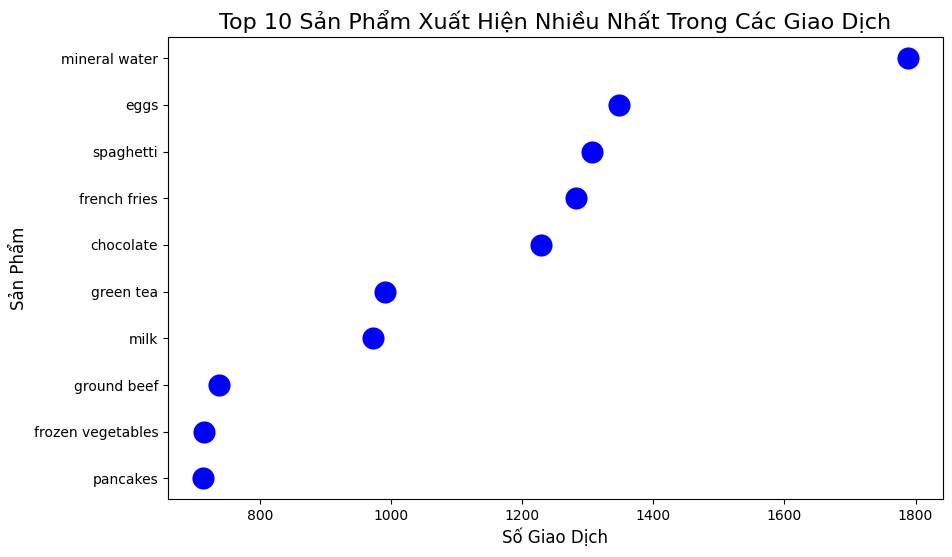

In [12]:
# Biểu đồ scatter plot hiển thị top 10 sản phẩm xuất hiện nhiều nhất trong các giao dịch
top_10_products = TID.head(10)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total Transactions', y='Item', data=top_10_products, s=300, color='blue')
plt.title('Top 10 Sản Phẩm Xuất Hiện Nhiều Nhất Trong Các Giao Dịch', fontsize=16)
plt.xlabel('Số Giao Dịch', fontsize=12)
plt.ylabel('Sản Phẩm', fontsize=12)
plt.show()

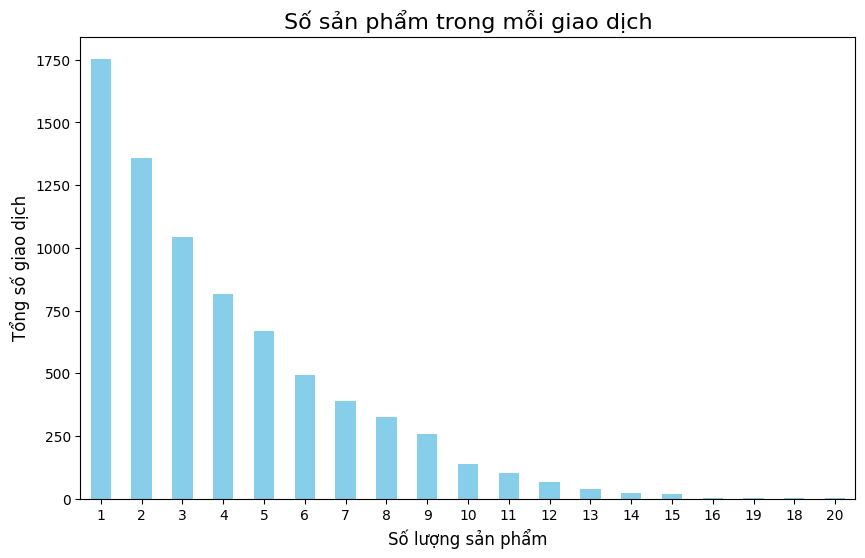

In [13]:
# Biểu đồ thể hiện số sản phẩm trong các giao dịch
row_items = df_cleaned.apply(lambda row: sum(1 for value in row if value not in (None, ' ')), axis=1)
counts = row_items.value_counts().sort_index()
counts_sorted = counts.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
counts_sorted.plot(kind='bar', color='skyblue')

plt.title('Số sản phẩm trong mỗi giao dịch', fontsize=16)
plt.xlabel('Số lượng sản phẩm', fontsize=12)
plt.ylabel('Tổng số giao dịch', fontsize=12)
plt.xticks(rotation=0)
plt.show()

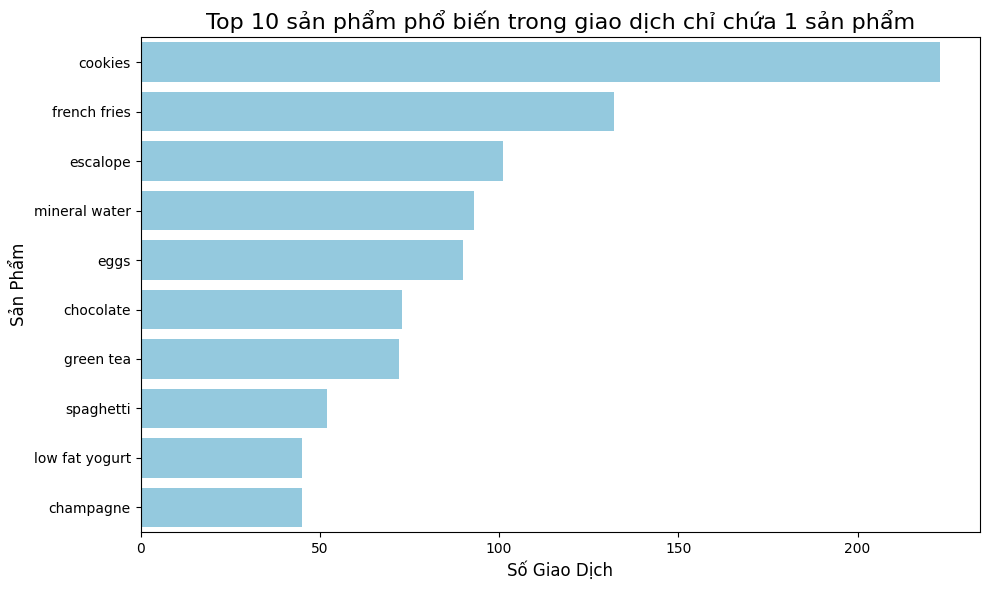

In [14]:
# Top 10 các sản phẩm phổ biến trong các giao dịch chỉ chứa 1 sản phẩm 
# Tính số lượng sản phẩm trong mỗi giao dịch
row_items = df_cleaned.apply(lambda row: sum(1 for value in row if value not in (None, ' ')), axis=1)
# Lọc các giao dịch chỉ chứa 1 sản phẩm
df_1_item = df_cleaned[row_items == 1]
# Lấy tên các sản phẩm
product_list_1 = df_1_item.values.flatten()
# Đếm tần suất và lấy top 10
product_freq_1 = pd.Series(product_list_1).value_counts().sort_values(ascending=False)
top_10_products_1 = product_freq_1.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_products_1.values, y=top_10_products_1.index, color='skyblue')
plt.title('Top 10 sản phẩm phổ biến trong giao dịch chỉ chứa 1 sản phẩm', fontsize=16)
plt.xlabel('Số Giao Dịch', fontsize=12)
plt.ylabel('Sản Phẩm', fontsize=12)
plt.tight_layout() 
plt.show()

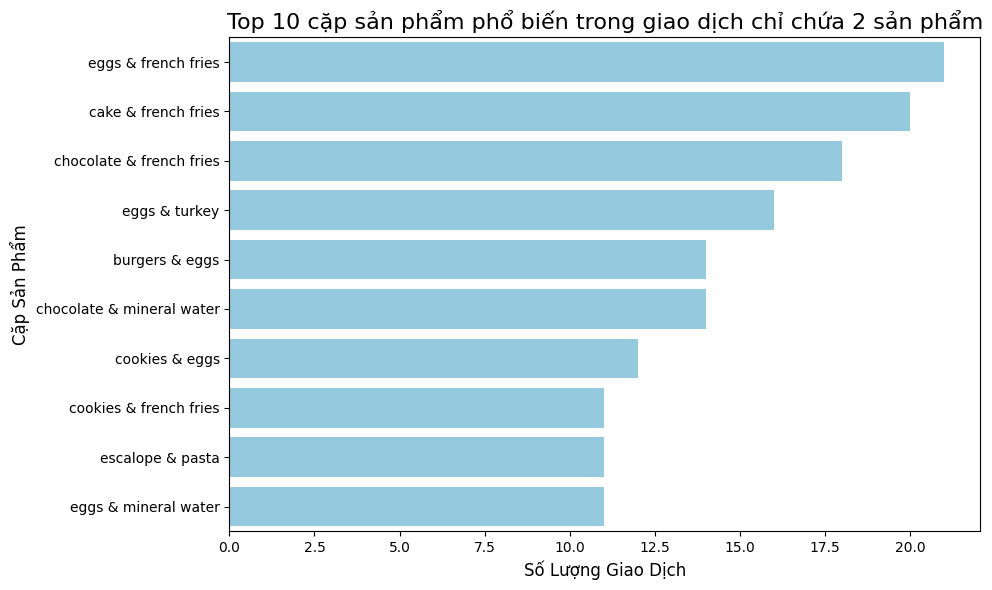

In [15]:
# Top 10 cặp sản phẩm phổ biến trong các giao dịch chỉ chứa 2 sản phẩm
# Tính số lượng sản phẩm trong mỗi giao dịch
row_items = df_cleaned.apply(lambda row: sum(1 for value in row if value not in (None, ' ')), axis=1)
# Lọc các giao dịch chỉ chứa 2 sản phẩm
df_2_items = df_cleaned[row_items == 2]
# Lấy các cặp sản phẩm từ các giao dịch chứa 2 sản phẩm
product_pairs_2 = []
for _, row in df_2_items.iterrows():
    products = [product for product in row if product not in (None, ' ')]
    if len(products) == 2:
        product_pairs_2.append(frozenset(products))  
# Bước 4: Tính tần suất và lấy top 10 các cặp sản phẩm
pair_freq_2 = pd.Series(product_pairs_2).value_counts().sort_values(ascending=False)
top_10_pairs_2 = pair_freq_2.head(10)
# Chuyển các cặp sản phẩm từ frozenset thành chuỗi có định dạng dễ đọc hơn
top_10_pairs_2_str = top_10_pairs_2.index.map(lambda x: ' & '.join(sorted(list(x))))
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_pairs_2.values, y=top_10_pairs_2_str, color='skyblue')
plt.title('Top 10 cặp sản phẩm phổ biến trong giao dịch chỉ chứa 2 sản phẩm', fontsize=16)
plt.xlabel('Số Lượng Giao Dịch', fontsize=12)
plt.ylabel('Cặp Sản Phẩm', fontsize=12)
plt.tight_layout() 
plt.show()

In [17]:
transaction_lengths = df_cleaned.notna().sum(axis=1)
rare_transactions = df_cleaned[transaction_lengths <= 3]
print(f'Number of rare transactions: {len(rare_transactions)}')

Number of rare transactions: 4156


In [18]:
sparsity = (df_cleaned.isna().sum().sum()) / (df_cleaned.size)
print(f'Sparsity of the dataset: {sparsity:.2f}')

Sparsity of the dataset: 0.80


---
# __ECLAT__

In [19]:
eclat = ECLAT(data=df_cleaned)
eclat.df_bin

,melons,dessert wine,chili,bug spray,white wine,milk,yogurt cake,gums,cider,frozen smoothie,...,pasta,mint,low fat yogurt,herb & pepper,green beans,black tea,toothpaste,turkey,magazines,asparagus
0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Bắt đầu thời gian tính toán
start_time = time.time()
# Đặt các tham số cho thuật toán ECLAT
min_combination = 1 
max_combination = 2 
# Chạy thuật toán ECLAT để khai phá các tập phổ biến
rule_indices, rule_supports = eclat.fit(
    min_support= 0.02,  
    min_combination=min_combination, 
    max_combination=max_combination,  
    separator=', ', 
    verbose=True
)
elapsed_time_eclat = time.time() - start_time

Combination 1 by 1


53it [00:02, 23.03it/s]


Combination 2 by 2


1378it [00:42, 32.45it/s]


In [21]:
# Đo thời gian thực thi
start_time = time.time()
# Chuyển đổi các khóa của tập phổ biến thành frozenset và đưa vào danh sách itemsets
itemsets = [frozenset(i.split(', ')) for i in rule_supports.keys()]
# Tạo DataFrame với các cột 'support' và 'itemsets' từ tập phổ biến
freq_itemsets = pd.DataFrame({
    'support': list(rule_supports.values()),
    'itemsets': itemsets
})
# Khai phá các luật kết hợp từ các tập phổ biến với minimum confidence
min_confidence = 0.3
rules_eclat = association_rules(freq_itemsets, num_itemsets=2, metric="confidence", min_threshold= min_confidence)
rules_eclat = rules_eclat[rules_eclat.lift > 1]
rules_eclat = rules_eclat.reset_index(drop=True)
elapsed_time_eclat = elapsed_time_eclat + time.time() - start_time
rules_eclat

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(milk),(mineral water),0.129583,0.238368,0.047994,0.370370,1.553774,1.0,0.017105,1.209650,0.409465,0.150000,0.173315,0.285856
1,(frozen smoothie),(mineral water),0.063325,0.238368,0.020264,0.320000,1.342461,1.0,0.005169,1.120047,0.272346,0.072004,0.107180,0.202506
2,(olive oil),(mineral water),0.065858,0.238368,0.027596,0.419028,1.757904,1.0,0.011898,1.310962,0.461536,0.099759,0.237201,0.267400
3,(olive oil),(spaghetti),0.065858,0.174110,0.022930,0.348178,1.999758,1.0,0.011464,1.267048,0.535186,0.105651,0.210764,0.239939
4,(soup),(mineral water),0.050527,0.238368,0.023064,0.456464,1.914955,1.0,0.011020,1.401255,0.503221,0.086760,0.286354,0.276610
5,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,1.0,0.017507,1.305401,0.474369,0.138413,0.233952,0.294127
6,(whole wheat rice),(mineral water),0.058526,0.238368,0.020131,0.343964,1.442993,1.0,0.006180,1.160960,0.326080,0.072736,0.138644,0.214208
7,(pancakes),(mineral water),0.095054,0.238368,0.033729,0.354839,1.488616,1.0,0.011071,1.180529,0.362712,0.112544,0.152922,0.248169
8,(shrimp),(mineral water),0.071457,0.238368,0.023597,0.330224,1.385352,1.0,0.006564,1.137144,0.299568,0.082441,0.120604,0.214609
9,(frozen vegetables),(mineral water),0.095321,0.238368,0.035729,0.374825,1.572463,1.0,0.013007,1.218270,0.402413,0.119911,0.179164,0.262357


---
# __APRIORI__

In [22]:
# Sử dụng apply để tạo danh sách giao dịch và loại bỏ giá trị là số
transaction = df_cleaned.apply(lambda row: [str(value) for value in row if value is not None and not isinstance(value, (int, float))], axis=1).tolist()
#sử dụng thư viện mlxtend để mã hóa one-hot các giao dịch
te = TransactionEncoder()
te_ary = te.fit(transaction).transform(transaction)
df_apriori = pd.DataFrame(te_ary, columns=te.columns_)

# Sử dụng thuật toán Apriori để tìm các tập phổ biến
start_time = time.time()
df_apriori1 = apriori(df_apriori, min_support=0.02, use_colnames=True)
df_apriori1.itemsets
elapsed_time_apriori = time.time() - start_time

# Sử dụng association_rules để khai phá các luật từ tập phổ biến tìm được
start_time = time.time()
min_confidence= 0.3
rules_apriori = association_rules(df_apriori1,num_itemsets=2, metric="confidence", min_threshold= min_confidence)
rules_apriori = rules_apriori[rules_apriori.lift > 1]
rules_apriori= rules_apriori.reset_index(drop=True)
elapsed_time_apriori = elapsed_time_apriori + time.time() - start_time
rules_apriori

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(burgers),(eggs),0.087188,0.179709,0.028796,0.330275,1.837830,1.0,0.013128,1.224818,0.499424,0.120941,0.183552,0.245256
1,(cake),(mineral water),0.081056,0.238368,0.027463,0.338816,1.421397,1.0,0.008142,1.151921,0.322617,0.094064,0.131885,0.227014
2,(chicken),(mineral water),0.059992,0.238368,0.022797,0.380000,1.594172,1.0,0.008497,1.228438,0.396502,0.082729,0.185958,0.237819
3,(chocolate),(mineral water),0.163845,0.238368,0.052660,0.321400,1.348332,1.0,0.013604,1.122357,0.308965,0.150648,0.109018,0.271158
4,(cooking oil),(mineral water),0.051060,0.238368,0.020131,0.394256,1.653978,1.0,0.007960,1.257349,0.416672,0.074752,0.204676,0.239354
5,(frozen smoothie),(mineral water),0.063325,0.238368,0.020264,0.320000,1.342461,1.0,0.005169,1.120047,0.272346,0.072004,0.107180,0.202506
6,(frozen vegetables),(mineral water),0.095321,0.238368,0.035729,0.374825,1.572463,1.0,0.013007,1.218270,0.402413,0.119911,0.179164,0.262357
7,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,1.0,0.017507,1.305401,0.474369,0.138413,0.233952,0.294127
8,(ground beef),(spaghetti),0.098254,0.174110,0.039195,0.398915,2.291162,1.0,0.022088,1.373997,0.624943,0.168096,0.272197,0.312015
9,(low fat yogurt),(mineral water),0.076523,0.238368,0.023997,0.313589,1.315565,1.0,0.005756,1.109585,0.259747,0.082493,0.098762,0.207130


---
# __FP-GROWTH__

In [23]:
df_fpgrowth = df_apriori

# Sử dụng thuật toán FP-growth để tìm các tập phổ biến
start_time = time.time()
df_fpgrowth1 = fpgrowth(df_fpgrowth, min_support=0.02, use_colnames=True)
df_fpgrowth1.itemsets
elapsed_time_fpgrowth = time.time() - start_time

# Sử dụng association_rules để khai phá các luật từ tập phổ biến tìm được
start_time = time.time()
min_confidence= 0.3
rules_fpgrowth = association_rules(df_fpgrowth1,num_itemsets=2, metric="confidence", min_threshold= min_confidence)
rules_fpgrowth = rules_fpgrowth[rules_fpgrowth.lift > 1]
rules_fpgrowth= rules_fpgrowth.reset_index(drop=True)
elapsed_time_fpgrowth = elapsed_time_fpgrowth + time.time() - start_time
rules_fpgrowth

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(low fat yogurt),(mineral water),0.076523,0.238368,0.023997,0.313589,1.315565,1.0,0.005756,1.109585,0.259747,0.082493,0.098762,0.207130
1,(shrimp),(mineral water),0.071457,0.238368,0.023597,0.330224,1.385352,1.0,0.006564,1.137144,0.299568,0.082441,0.120604,0.214609
2,(olive oil),(mineral water),0.065858,0.238368,0.027596,0.419028,1.757904,1.0,0.011898,1.310962,0.461536,0.099759,0.237201,0.267400
3,(olive oil),(spaghetti),0.065858,0.174110,0.022930,0.348178,1.999758,1.0,0.011464,1.267048,0.535186,0.105651,0.210764,0.239939
4,(frozen smoothie),(mineral water),0.063325,0.238368,0.020264,0.320000,1.342461,1.0,0.005169,1.120047,0.272346,0.072004,0.107180,0.202506
5,(burgers),(eggs),0.087188,0.179709,0.028796,0.330275,1.837830,1.0,0.013128,1.224818,0.499424,0.120941,0.183552,0.245256
6,(milk),(mineral water),0.129583,0.238368,0.047994,0.370370,1.553774,1.0,0.017105,1.209650,0.409465,0.150000,0.173315,0.285856
7,(whole wheat rice),(mineral water),0.058526,0.238368,0.020131,0.343964,1.442993,1.0,0.006180,1.160960,0.326080,0.072736,0.138644,0.214208
8,(soup),(mineral water),0.050527,0.238368,0.023064,0.456464,1.914955,1.0,0.011020,1.401255,0.503221,0.086760,0.286354,0.276610
9,(spaghetti),(mineral water),0.174110,0.238368,0.059725,0.343032,1.439085,1.0,0.018223,1.159314,0.369437,0.169312,0.137421,0.296796


---
# __SO SÁNH__

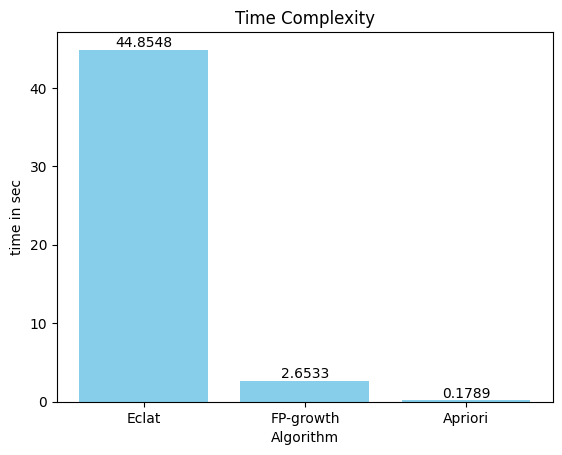

In [24]:
x = ["Eclat", "FP-growth", "Apriori"]
y = [elapsed_time_eclat, elapsed_time_fpgrowth, elapsed_time_apriori]
plt.bar(x, y, color='skyblue')
plt.xlabel("Algorithm")
plt.ylabel("time in sec")
plt.title("Time Complexity")
for i, v in enumerate(y):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.show()

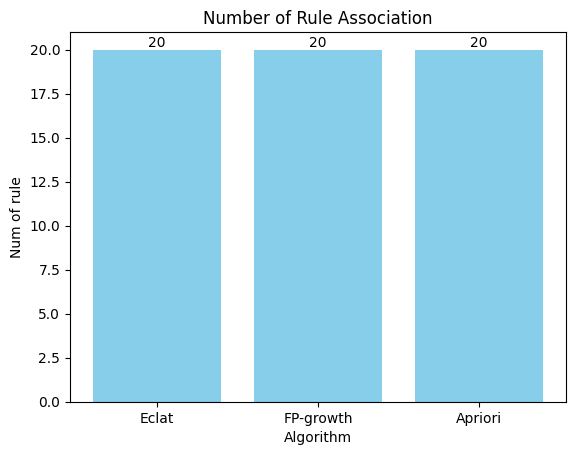

In [25]:
x = ["Eclat", "FP-growth", "Apriori"]
y = [len(rules_eclat), len(rules_fpgrowth), len(rules_apriori)]
plt.bar(x, y, color='skyblue')
plt.xlabel("Algorithm")
plt.ylabel("Num of rule")
plt.title("Number of Rule Association")
for i, v in enumerate(y):
    plt.text(i, v, f'{v:.0f}', ha='center', va='bottom')
plt.show()

Đang tính toán với min_support = 0.01...
Combination 1 by 1


75it [00:06, 11.16it/s]


Combination 2 by 2


2775it [02:08, 21.59it/s]


Đang tính toán với min_support = 0.02...
Combination 1 by 1


53it [00:01, 27.22it/s]


Combination 2 by 2


1378it [00:38, 35.48it/s]


Đang tính toán với min_support = 0.03...
Combination 1 by 1


36it [00:02, 12.93it/s]


Combination 2 by 2


630it [00:24, 25.24it/s]


Đang tính toán với min_support = 0.04...
Combination 1 by 1


30it [00:02, 13.33it/s]


Combination 2 by 2


435it [00:17, 25.44it/s]


Đang tính toán với min_support = 0.05...
Combination 1 by 1


25it [00:02, 12.29it/s]


Combination 2 by 2


300it [00:11, 25.41it/s]


Đang tính toán với min_support = 0.06...
Combination 1 by 1


20it [00:01, 12.07it/s]


Combination 2 by 2


190it [00:07, 26.14it/s]


Đang tính toán với min_support = 0.07...
Combination 1 by 1


16it [00:01, 11.27it/s]


Combination 2 by 2


120it [00:04, 27.12it/s]


Đang tính toán với min_support = 0.08...
Combination 1 by 1


13it [00:01, 12.32it/s]


Combination 2 by 2


78it [00:02, 26.26it/s]


Đang tính toán với min_support = 0.09...
Combination 1 by 1


10it [00:00, 12.20it/s]


Combination 2 by 2


45it [00:01, 22.77it/s]


Đang tính toán với min_support = 0.10...
Combination 1 by 1


7it [00:00, 11.55it/s]


Combination 2 by 2


21it [00:01, 19.27it/s]


   minsup       ECLAT   Apriori  FP-growth
0    0.01  135.496331  0.329893   4.019613
1    0.02   40.839763  0.162515   2.148480
2    0.03   27.846724  0.060230   1.029734
3    0.04   19.452471  0.040510   0.447198
4    0.05   13.980082  0.030477   0.275100
5    0.06    9.053995  0.018096   0.146631
6    0.07    5.928923  0.016090   0.146950
7    0.08    4.111012  0.014249   0.126432
8    0.09    2.884261  0.012351   0.138500
9    0.10    1.783048  0.016807   0.114938


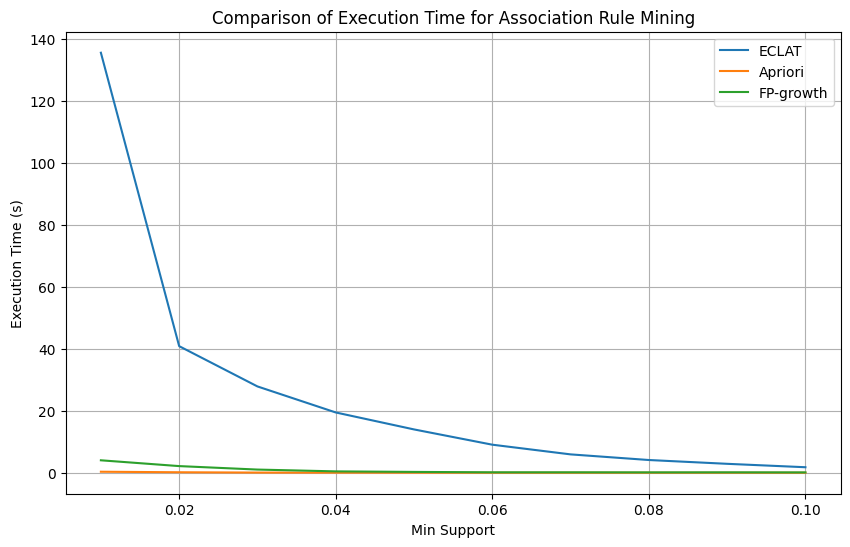

In [26]:
df=df_cleaned
eclat = ECLAT(data=df)
# Chuẩn hóa dữ liệu giao dịch bằng TransactionEncoder
transaction = df.apply(lambda row: [str(value) for value in row if value is not None and not isinstance(value, (int, float))], axis=1).tolist()
te = TransactionEncoder()
te_ary = te.fit(transaction).transform(transaction)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Khởi tạo danh sách lưu kết quả thời gian
time_results = {
    'minsup': [],
    'ECLAT': [],
    'Apriori': [],
    'FP-growth': []
}

# Phạm vi giá trị cho min_support
minsup_range = np.linspace(0.01, 0.1, 10)
min_confidence = 0.3 
for minsup in minsup_range:
    print(f"Đang tính toán với min_support = {minsup:.2f}...")

    # ECLAT
    eclat_start_time = time.time()
    rule_indices, rule_supports = eclat.fit(
        min_support=minsup,
        min_combination=1,
        max_combination=2,
        separator=', '
    )
    # Chuyển đổi các khóa của tập phổ biến thành frozenset và đưa vào danh sách itemsets
    itemsets = [frozenset(i.split(', ')) for i in rule_supports.keys()]
    # Tạo DataFrame với các cột 'support' và 'itemsets' từ tập phổ biến
    freq_itemsets = pd.DataFrame({
        'support': list(rule_supports.values()),
        'itemsets': itemsets
    })
    rules_eclat = association_rules(
        freq_itemsets, metric="confidence", min_threshold=min_confidence, num_itemsets =2
    )
    eclat_end_time = time.time()
    time_results['ECLAT'].append(eclat_end_time - eclat_start_time)

    # Apriori
    apriori_start_time = time.time()
    df_apriori = apriori(df, min_support=minsup, use_colnames=True)
    rules_apriori = association_rules(
        df_apriori, metric="confidence", min_threshold=min_confidence, num_itemsets =2
    )
    apriori_end_time = time.time()
    time_results['Apriori'].append(apriori_end_time - apriori_start_time)

    # FP-growth
    fpgrowth_start_time = time.time()
    df_fpgrowth = fpgrowth(df, min_support=minsup, use_colnames=True)
    rules_fpgrowth = association_rules(
        df_fpgrowth, metric="confidence", min_threshold=min_confidence, num_itemsets =2
    )
    fpgrowth_end_time = time.time()
    time_results['FP-growth'].append(fpgrowth_end_time - fpgrowth_start_time)

    # Lưu giá trị min_support
    time_results['minsup'].append(minsup)

time_df = pd.DataFrame(time_results)
print(time_df)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(10, 6))
plt.plot(time_df['minsup'], time_df['ECLAT'], label='ECLAT')
plt.plot(time_df['minsup'], time_df['Apriori'], label='Apriori')
plt.plot(time_df['minsup'], time_df['FP-growth'], label='FP-growth')
plt.xlabel('Min Support')
plt.ylabel('Execution Time (s)')
plt.title('Comparison of Execution Time for Association Rule Mining')
plt.legend()
plt.grid()
plt.show()

Đang tính toán với min_support = 0.01...
Combination 1 by 1


75it [00:05, 13.16it/s]


Combination 2 by 2


2775it [01:06, 41.73it/s]


Đang tính toán với min_support = 0.02...
Combination 1 by 1


53it [00:02, 23.50it/s]


Combination 2 by 2


1378it [00:50, 27.37it/s]


Đang tính toán với min_support = 0.03...
Combination 1 by 1


36it [00:02, 12.21it/s]


Combination 2 by 2


630it [00:24, 25.21it/s]


Đang tính toán với min_support = 0.04...
Combination 1 by 1


30it [00:02, 13.51it/s]


Combination 2 by 2


435it [00:17, 25.53it/s]


Đang tính toán với min_support = 0.05...
Combination 1 by 1


25it [00:01, 12.86it/s]


Combination 2 by 2


300it [00:12, 24.68it/s]


Đang tính toán với min_support = 0.06...
Combination 1 by 1


20it [00:01, 11.05it/s]


Combination 2 by 2


190it [00:08, 21.38it/s]


Đang tính toán với min_support = 0.07...
Combination 1 by 1


16it [00:01,  9.35it/s]


Combination 2 by 2


120it [00:07, 15.56it/s]


Đang tính toán với min_support = 0.08...
Combination 1 by 1


13it [00:02,  4.98it/s]


Combination 2 by 2


78it [00:04, 16.69it/s]


Đang tính toán với min_support = 0.09...
Combination 1 by 1


10it [00:01,  9.95it/s]


Combination 2 by 2


45it [00:02, 20.32it/s]


Đang tính toán với min_support = 0.10...
Combination 1 by 1


7it [00:00, 10.07it/s]


Combination 2 by 2


21it [00:01, 18.16it/s]


   minsup  ECLAT  Apriori  FP-growth
0    0.01     37       63         63
1    0.02     20       20         20
2    0.03      7        7          7
3    0.04      4        4          4
4    0.05      2        2          2
5    0.06      0        0          0
6    0.07      0        0          0
7    0.08      0        0          0
8    0.09      0        0          0
9    0.10      0        0          0


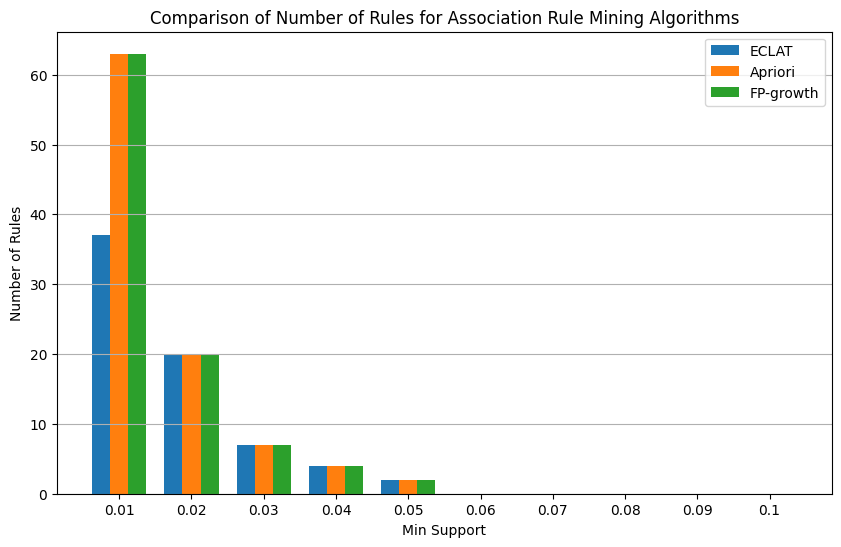

In [27]:
df=df_cleaned
eclat = ECLAT(data=df)
# Chuẩn hóa dữ liệu giao dịch bằng TransactionEncoder
transaction = df.apply(lambda row: [str(value) for value in row if value is not None and not isinstance(value, (int, float))], axis=1).tolist()
te = TransactionEncoder()
te_ary = te.fit(transaction).transform(transaction)
df = pd.DataFrame(te_ary, columns=te.columns_)
# Khởi tạo danh sách lưu kết quả số lượng luật
rule_count_results = {
    'minsup': [],
    'ECLAT': [],
    'Apriori': [],
    'FP-growth': []
}

for minsup in minsup_range:
    print(f"Đang tính toán với min_support = {minsup:.2f}...")

    # ECLAT
    eclat_start_time = time.time()
    rule_indices, rule_supports = eclat.fit(
        min_support=minsup,
        min_combination=1,
        max_combination=2,
        separator=', '
    )
    itemsets = [frozenset(i.split(', ')) for i in rule_supports.keys()]
    freq_itemsets = pd.DataFrame({
        'support': list(rule_supports.values()),
        'itemsets': itemsets
    })
    rules_eclat = association_rules(
        freq_itemsets, metric="confidence", min_threshold=min_confidence, num_itemsets=2
    )
    eclat_end_time = time.time()
    rule_count_results['ECLAT'].append(len(rules_eclat))

    # Apriori
    apriori_start_time = time.time()
    df_apriori = apriori(df, min_support=minsup, use_colnames=True)
    rules_apriori = association_rules(
        df_apriori, metric="confidence", min_threshold=min_confidence, num_itemsets=2
    )
    apriori_end_time = time.time()
    rule_count_results['Apriori'].append(len(rules_apriori))

    # FP-growth
    fpgrowth_start_time = time.time()
    df_fpgrowth = fpgrowth(df, min_support=minsup, use_colnames=True)
    rules_fpgrowth = association_rules(
        df_fpgrowth, metric="confidence", min_threshold=min_confidence, num_itemsets=2
    )
    fpgrowth_end_time = time.time()
    rule_count_results['FP-growth'].append(len(rules_fpgrowth))

    # Lưu giá trị min_support
    rule_count_results['minsup'].append(minsup)

rule_count_df = pd.DataFrame(rule_count_results)
print(rule_count_df)

# Vẽ biểu đồ cột thể hiện số lượng luật
plt.figure(figsize=(10, 6))
bar_width = 0.25 
index = np.arange(len(rule_count_df))
plt.bar(index - bar_width, rule_count_df['ECLAT'], bar_width, label='ECLAT')
plt.bar(index, rule_count_df['Apriori'], bar_width, label='Apriori')
plt.bar(index + bar_width, rule_count_df['FP-growth'], bar_width, label='FP-growth')
plt.xlabel('Min Support')
plt.ylabel('Number of Rules')
plt.title('Comparison of Number of Rules for Association Rule Mining Algorithms')
plt.xticks(index, rule_count_df['minsup'].round(2))
plt.legend()
plt.grid(axis='y')
plt.show()